<a href="https://colab.research.google.com/github/Robertocarbonee/Finance-Physics/blob/main/Etherium_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

from itertools import product
import statsmodels.api as sm

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM

from itertools import cycle
import plotly.offline as py
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots


In [35]:
# You can also get the dataset from Kaggle ( I uploaded the whole .csv file here)
# https://www.kaggle.com/paulrohan2020/bitcoin-historic-prices-from-oct2015-to-oct2021

# For accessing the dataset from my google drive while running the code in Colab
# root_path = '/content/drive/MyDrive/Datasets_For_Working/Bitcoin_2015-2021-30-Oct-2021/3_pull.csv'

# The dataset in local machine
root_path = 'ETHUSD_1m_Binance.csv'

# btc_input_df = pd.read_csv(root_path, nrows=500)
btc_input_df = pd.read_csv(root_path)
btc_input_df.tail()

,Open time,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Ignore
3799603,2024-11-12 18:35:00,3281.41,3285.54,3279.71,3282.45,558.0089,2024-11-12 18:35:59.999,1.831906e+06,3241.0,329.3314,1.081074e+06,0.0
3799604,2024-11-12 18:36:00,3282.45,3284.79,3271.00,3271.00,685.8656,2024-11-12 18:36:59.999,2.248745e+06,4947.0,238.0714,7.807082e+05,0.0
3799605,2024-11-12 18:37:00,3271.01,3275.99,3270.86,3273.49,510.6305,2024-11-12 18:37:59.999,1.671488e+06,3384.0,235.8709,7.720204e+05,0.0
3799606,2024-11-12 18:38:00,3273.50,3276.47,3271.35,3272.18,349.7489,2024-11-12 18:38:59.999,1.144899e+06,3707.0,187.0437,6.122436e+05,0.0
3799607,2024-11-12 18:39:00,3272.18,3273.95,3271.50,3273.36,116.6739,2024-11-12 18:39:59.999,3.818264e+05,1814.0,71.5155,2.340268e+05,0.0


In [36]:
btc_input_df.shape


(3799608, 12)

In [37]:
btc_input_df.describe()

,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Ignore
count,3.799608e+06,3.799608e+06,3.799608e+06,3.799608e+06,3.799608e+06,3.799608e+06,3.799608e+06,3.799608e+06,3.799608e+06,3799608.0
mean,1.415516e+03,1.416425e+03,1.414601e+03,1.415516e+03,3.645577e+02,5.267196e+05,4.585371e+02,1.821470e+02,2.624742e+05,0.0
std,1.202470e+03,1.203176e+03,1.201762e+03,1.202472e+03,6.892075e+02,1.200947e+06,8.147689e+02,3.594891e+02,6.221242e+05,0.0
min,8.202000e+01,8.208000e+01,8.179000e+01,8.203000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
25%,2.689000e+02,2.690800e+02,2.687000e+02,2.689000e+02,7.001719e+01,3.419923e+04,8.400000e+01,3.035869e+01,1.491201e+04,0.0
50%,1.259100e+03,1.260000e+03,1.258110e+03,1.259110e+03,1.698691e+02,1.646124e+05,2.310000e+02,8.061930e+01,7.482313e+04,0.0
75%,2.288840e+03,2.290010e+03,2.287540e+03,2.288832e+03,3.901635e+02,5.491620e+05,5.200000e+02,1.932195e+02,2.672805e+05,0.0
max,4.865220e+03,4.868000e+03,4.861380e+03,4.865220e+03,4.013161e+04,9.757289e+07,6.375100e+04,2.374347e+04,5.018841e+07,0.0


In [38]:
btc_input_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3799608 entries, 0 to 3799607
Data columns (total 12 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   Open time                     object 
 1   Open                          float64
 2   High                          float64
 3   Low                           float64
 4   Close                         float64
 5   Volume                        float64
 6   Close time                    object 
 7   Quote asset volume            float64
 8   Number of trades              float64
 9   Taker buy base asset volume   float64
 10  Taker buy quote asset volume  float64
 11  Ignore                        float64
dtypes: float64(10), object(2)
memory usage: 347.9+ MB


In [39]:
# Convert both 'Open time' and 'Close time' columns to datetime using astype
btc_input_df_datetype = btc_input_df.astype({'Open time': 'datetime64[ns]', 'Close time': 'datetime64[ns]'})

# Verify the conversion
btc_input_df_datetype.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3799608 entries, 0 to 3799607
Data columns (total 12 columns):
 #   Column                        Dtype         
---  ------                        -----         
 0   Open time                     datetime64[ns]
 1   Open                          float64       
 2   High                          float64       
 3   Low                           float64       
 4   Close                         float64       
 5   Volume                        float64       
 6   Close time                    datetime64[ns]
 7   Quote asset volume            float64       
 8   Number of trades              float64       
 9   Taker buy base asset volume   float64       
 10  Taker buy quote asset volume  float64       
 11  Ignore                        float64       
dtypes: datetime64[ns](2), float64(10)
memory usage: 347.9 MB


In [40]:
print('Null Values:',btc_input_df_datetype.isnull().values.sum())
print('If any NA values:', btc_input_df_datetype.isnull().values.any())



Null Values: 0
If any NA values: False


In [42]:
btc_input_df_datetype.tail()



,Open time,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Ignore
3799603,2024-11-12 18:35:00,3281.41,3285.54,3279.71,3282.45,558.0089,2024-11-12 18:35:59.999,1.831906e+06,3241.0,329.3314,1.081074e+06,0.0
3799604,2024-11-12 18:36:00,3282.45,3284.79,3271.00,3271.00,685.8656,2024-11-12 18:36:59.999,2.248745e+06,4947.0,238.0714,7.807082e+05,0.0
3799605,2024-11-12 18:37:00,3271.01,3275.99,3270.86,3273.49,510.6305,2024-11-12 18:37:59.999,1.671488e+06,3384.0,235.8709,7.720204e+05,0.0
3799606,2024-11-12 18:38:00,3273.50,3276.47,3271.35,3272.18,349.7489,2024-11-12 18:38:59.999,1.144899e+06,3707.0,187.0437,6.122436e+05,0.0
3799607,2024-11-12 18:39:00,3272.18,3273.95,3271.50,3273.36,116.6739,2024-11-12 18:39:59.999,3.818264e+05,1814.0,71.5155,2.340268e+05,0.0


In [43]:
btc_input_df_datetype.head()


,Open time,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Ignore
0,2017-08-17 04:00:00,301.13,301.13,301.13,301.13,0.42643,2017-08-17 04:00:59.999,128.410866,2.0,0.42643,128.410866,0.0
1,2017-08-17 04:01:00,301.13,301.13,301.13,301.13,2.75787,2017-08-17 04:01:59.999,830.477393,4.0,2.75787,830.477393,0.0
2,2017-08-17 04:02:00,300.00,300.00,300.00,300.00,0.09930,2017-08-17 04:02:59.999,29.790000,2.0,0.09930,29.790000,0.0
3,2017-08-17 04:03:00,300.00,300.00,300.00,300.00,0.31389,2017-08-17 04:03:59.999,94.167000,3.0,0.00000,0.000000,0.0
4,2017-08-17 04:04:00,301.13,301.13,301.13,301.13,0.23202,2017-08-17 04:04:59.999,69.868183,1.0,0.23202,69.868183,0.0


In [48]:
!pip install seaborn




In [49]:
import matplotlib.pyplot as plt
print(plt.style.available)


['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


<Axes: title={'center': 'Etherium Weighted Price'}, xlabel='Open time'>

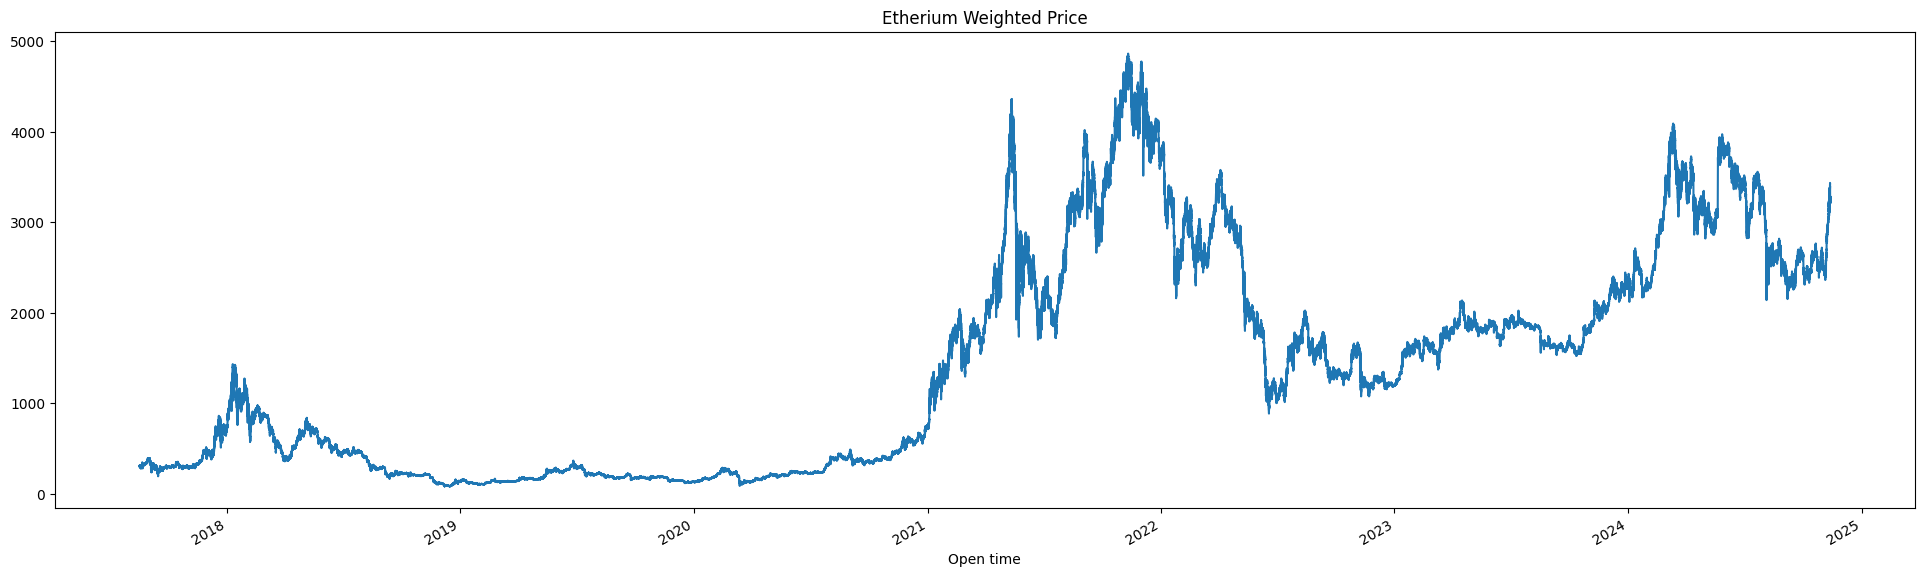

In [56]:
btc_input_df_datetype.set_index("Open time")['Close'].plot(figsize=(24, 7), title="Etherium Weighted Price")


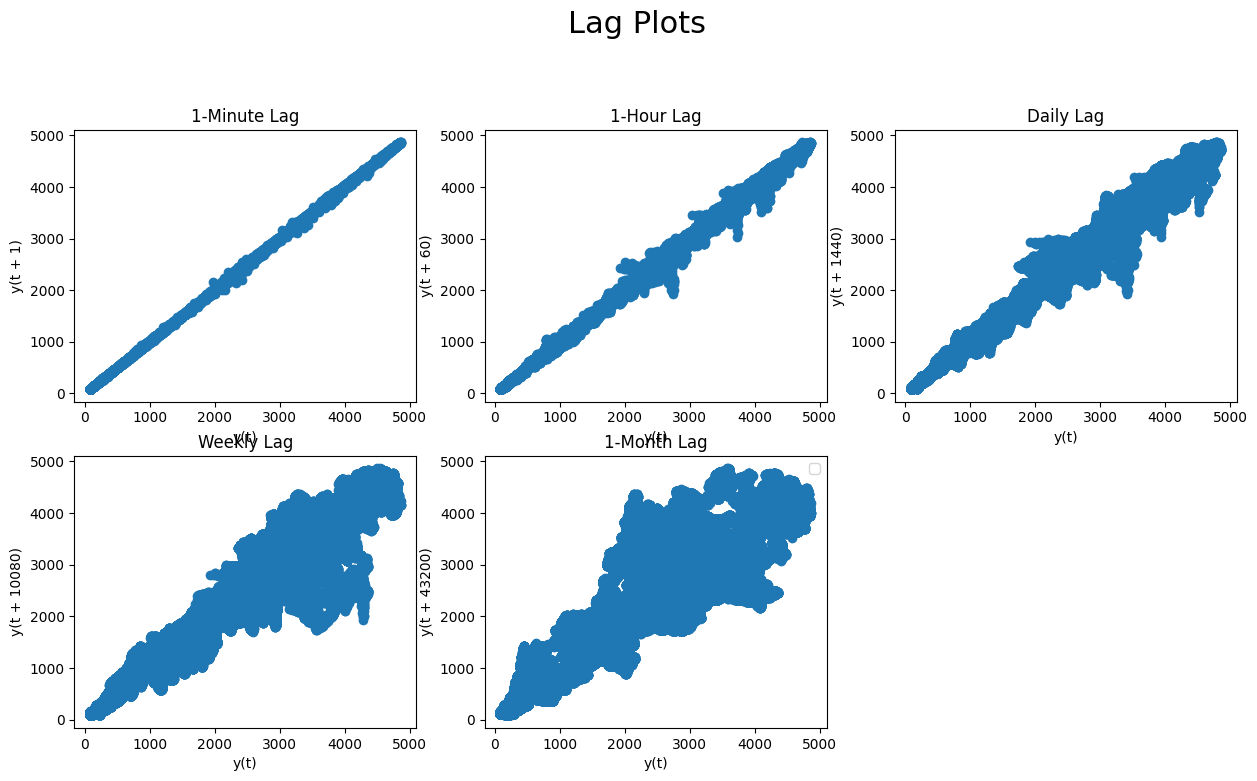

In [58]:
plt.figure(figsize=(15,12))
plt.suptitle('Lag Plots', fontsize=22)

plt.subplot(3,3,1)
pd.plotting.lag_plot(btc_input_df_datetype['Close'], lag=1) #minute lag
plt.title('1-Minute Lag')

plt.subplot(3,3,2)
pd.plotting.lag_plot(btc_input_df_datetype['Close'], lag=60) #hourley lag
plt.title('1-Hour Lag')

plt.subplot(3,3,3)
pd.plotting.lag_plot(btc_input_df_datetype['Close'], lag=1440) #Daily lag
plt.title('Daily Lag')

plt.subplot(3,3,4)
pd.plotting.lag_plot(btc_input_df_datetype['Close'], lag=10080) #weekly lag
plt.title('Weekly Lag')

plt.subplot(3,3,5)
pd.plotting.lag_plot(btc_input_df_datetype['Close'], lag=43200) #month lag
plt.title('1-Month Lag')

plt.legend()
plt.show()

In [61]:
btc_input_df_datetype['date'] = pd.to_datetime(btc_input_df_datetype['Close time'],unit='s').dt.date

display(btc_input_df_datetype.head())

group = btc_input_df_datetype.groupby('date')

btc_closing_price_groupby_date = group['Close'].mean()

,Open time,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Ignore,date
0,2017-08-17 04:00:00,301.13,301.13,301.13,301.13,0.42643,2017-08-17 04:00:59.999,128.410866,2.0,0.42643,128.410866,0.0,2017-08-17
1,2017-08-17 04:01:00,301.13,301.13,301.13,301.13,2.75787,2017-08-17 04:01:59.999,830.477393,4.0,2.75787,830.477393,0.0,2017-08-17
2,2017-08-17 04:02:00,300.00,300.00,300.00,300.00,0.09930,2017-08-17 04:02:59.999,29.790000,2.0,0.09930,29.790000,0.0,2017-08-17
3,2017-08-17 04:03:00,300.00,300.00,300.00,300.00,0.31389,2017-08-17 04:03:59.999,94.167000,3.0,0.00000,0.000000,0.0,2017-08-17
4,2017-08-17 04:04:00,301.13,301.13,301.13,301.13,0.23202,2017-08-17 04:04:59.999,69.868183,1.0,0.23202,69.868183,0.0,2017-08-17


In [62]:
display(btc_closing_price_groupby_date.head(10))

print("Length of btc_closing_price_groupby_date :", len(btc_closing_price_groupby_date))

,Close
date,
2017-08-17,306.863258
2017-08-18,300.756104
2017-08-19,291.003083
2017-08-20,294.195924
2017-08-21,320.167090
2017-08-22,308.052944
2017-08-23,317.534472
2017-08-24,319.767097
2017-08-25,330.372299


Length of btc_closing_price_groupby_date : 2645


In [63]:
prediction_days = 60

# Set Train data to be uplo ( Total data length - prediction_days )
df_train= btc_closing_price_groupby_date[:len(btc_closing_price_groupby_date)-prediction_days].values.reshape(-1,1)


# Set Test data to be the last prediction_days (or 60 days in this case)
df_test= btc_closing_price_groupby_date[len(btc_closing_price_groupby_date)-prediction_days:].values.reshape(-1,1)

In [64]:
df_test.shape


(60, 1)

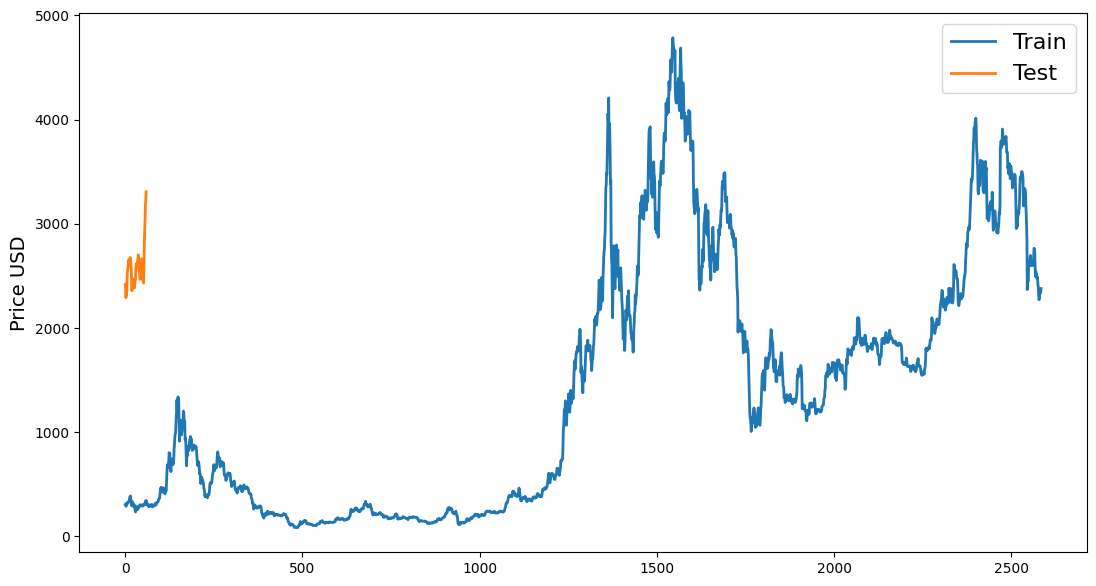

In [65]:
chosen_col = 'Close'

fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(df_train, label='Train', linewidth=2)
ax.plot(df_test, label='Test', linewidth=2)
ax.set_ylabel('Price USD', fontsize=14)
ax.set_title('', fontsize=16)
ax.legend(loc='best', fontsize=16)

In [66]:
scaler_train = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler_train.fit_transform(df_train)

scaler_test = MinMaxScaler(feature_range=(0, 1))
scaled_test = scaler_test.fit_transform(df_test)

In [67]:
def dataset_generator_lstm(dataset, look_back=5):
    """
    Generates input-output pairs for an LSTM dataset.

    Args:
        dataset (numpy.ndarray): The dataset to generate input-output pairs from.
        look_back (int): The number of previous timesteps to use for prediction.

    Returns:
        numpy.ndarray: The input sequences.
        numpy.ndarray: The corresponding output values.
    """
    # A “lookback period” defines the window-size of how many
    # previous timesteps are used in order to predict
    # the subsequent timestep.
    dataX, dataY = [], []

    # Iterate over the dataset, considering a "look_back" window of previous timesteps
    for i in range(len(dataset) - look_back):
        window_size_x = dataset[i:(i + look_back), 0]
        dataX.append(window_size_x)
        dataY.append(dataset[i + look_back, 0]) # this is the label or actual y-value
    return np.array(dataX), np.array(dataY)

trainX, trainY = dataset_generator_lstm(scaled_train)

testX, testY = dataset_generator_lstm(scaled_test)

print("trainX: ", trainX.shape)
print("trainY: ", trainY.shape)
print("testX: ", testX.shape)
print("testY", testY.shape)

trainX:  (2580, 5)
trainY:  (2580,)
testX:  (55, 5)
testY (55,)


In [68]:
print("trainX: ", trainX)
# print("trainY: ", trainY)
# print("testY: ", testX)
# print("testY", testY)

trainX:  [[0.04745842 0.04615969 0.04408563 0.04476461 0.05028759]
 [0.04615969 0.04408563 0.04476461 0.05028759 0.04771142]
 [0.04408563 0.04476461 0.05028759 0.04771142 0.04972774]
 ...
 [0.47604079 0.46544747 0.46783552 0.47548802 0.48278059]
 [0.46544747 0.46783552 0.47548802 0.48278059 0.47927638]
 [0.46783552 0.47548802 0.48278059 0.47927638 0.48270456]]


In [69]:
print(trainX.shape)
print(testX.shape)


(2580, 5)
(55, 5)


In [70]:
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))

testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1 ))

print("Shape of trainX: ", trainX.shape)
print("Shape of testX: ", testX.shape)

Shape of trainX:  (2580, 5, 1)
Shape of testX:  (55, 5, 1)


In [71]:
print("trainX: ", trainX)
print(" ********** ")
print("testX: ", testX)

trainX:  [[[0.04745842]
  [0.04615969]
  [0.04408563]
  [0.04476461]
  [0.05028759]]

 [[0.04615969]
  [0.04408563]
  [0.04476461]
  [0.05028759]
  [0.04771142]]

 [[0.04408563]
  [0.04476461]
  [0.05028759]
  [0.04771142]
  [0.04972774]]

 ...

 [[0.47604079]
  [0.46544747]
  [0.46783552]
  [0.47548802]
  [0.48278059]]

 [[0.46544747]
  [0.46783552]
  [0.47548802]
  [0.48278059]
  [0.47927638]]

 [[0.46783552]
  [0.47548802]
  [0.48278059]
  [0.47927638]
  [0.48270456]]]
 ********** 
testX:  [[[0.12522101]
  [0.10554967]
  [0.        ]
  [0.03042455]
  [0.02748009]]

 [[0.10554967]
  [0.        ]
  [0.03042455]
  [0.02748009]
  [0.1410725 ]]

 [[0.        ]
  [0.03042455]
  [0.02748009]
  [0.1410725 ]
  [0.23603747]]

 [[0.03042455]
  [0.02748009]
  [0.1410725 ]
  [0.23603747]
  [0.26261097]]

 [[0.02748009]
  [0.1410725 ]
  [0.23603747]
  [0.26261097]
  [0.28663506]]

 [[0.1410725 ]
  [0.23603747]
  [0.26261097]
  [0.28663506]
  [0.35407665]]

 [[0.23603747]
  [0.26261097]
  [0.28663

In [72]:
# First checking the values for input_shape = (trainX.shape[1], trainX.shape[2])
# Note - `input_shape` of LSTM Model - `input_shape` is supposed to be (timesteps, n_features).

print("trainX.shape[1] - i.e. timesteps in input_shape = (timesteps, n_features) ", trainX.shape[1])
print("trainX.shape[2] - i.e. n_features in input_shape = (timesteps, n_features) ", trainX.shape[2])

trainX.shape[1] - i.e. timesteps in input_shape = (timesteps, n_features)  5
trainX.shape[2] - i.e. n_features in input_shape = (timesteps, n_features)  1


In [73]:
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
# You must set return_sequences=True when stacking LSTM layers so that the second LSTM layer
# has a compatible n-dimensional sequence input.
# This hyper parameter should be set to False (which is the default value) for the last layer
# and true for the other previous layers.

regressor.add(LSTM(units = 128, activation = 'relu',return_sequences=True, input_shape = (trainX.shape[1], trainX.shape[2])))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 64, input_shape = (trainX.shape[1], trainX.shape[2])))
# regressor.add(LSTM(units = 64, return_sequences = True, input_shape = (trainX.shape[1], trainX.shape[2])))
regressor.add(Dropout(0.2))
# Note - If I plan to add 3-rd or 4-th layers of LSTM then
# I must set return_sequences=True in the 2-nd layer above
# so that the 3-rd LSTM layer has a compatible n-dimensional sequence input.


# Adding a third LSTM layer and some Dropout regularisation
# regressor.add(LSTM(units = 64, return_sequences = True, input_shape = (trainX.shape[1], trainX.shape[2])))
# regressor.add(Dropout(0.2))


# Adding a fourth LSTM layer and some Dropout regularisation
# regressor.add(LSTM(units = 64, input_shape = (trainX.shape[1], trainX.shape[2])))
# regressor.add(Dropout(0.2))


# Adding the output layer
regressor.add(Dense(units = 1))

regressor.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 5, 128)              │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 5, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 116,033 (453.25 KB)

 Trainable params: 116,033 (453.25 KB)

 Non-trainable params: 0 (0.00 B)

In [75]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Compiling the LSTM
regressor.compile(optimizer='adam', loss='mean_squared_error')

# Use the `.keras` extension for the checkpoint path
checkpoint_path = 'my_best_model.keras'

# Define the ModelCheckpoint and EarlyStopping callbacks
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')

earlystopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Add the callbacks to a list
callbacks = [checkpoint, earlystopping]

# Fit the model with callbacks
history = regressor.fit(trainX, trainY, batch_size=32, epochs=600, verbose=1, shuffle=False, validation_data=(testX, testY), callbacks=callbacks)


Epoch 1/600
78/81 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0179
Epoch 1: val_loss improved from inf to 0.02701, saving model to my_best_model.keras
81/81 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.0188 - val_loss: 0.0270
Epoch 2/600
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0176
Epoch 2: val_loss improved from 0.02701 to 0.02450, saving model to my_best_model.keras
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0176 - val_loss: 0.0245
Epoch 3/600
77/81 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0023
Epoch 3: val_loss did not improve from 0.02450
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0024 - val_loss: 0.0247
Epoch 4/600
78/81 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0020
Epoch 4: val_loss did not improve from 0.02450
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0021 - val_loss: 0.0254
Epoch 5/600
79/81 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0043
Epoch 5: val_loss did not improve from 0.02450
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0043 -

In [76]:
from tensorflow.keras.models import load_model

model_from_saved_checkpoint = load_model(checkpoint_path)

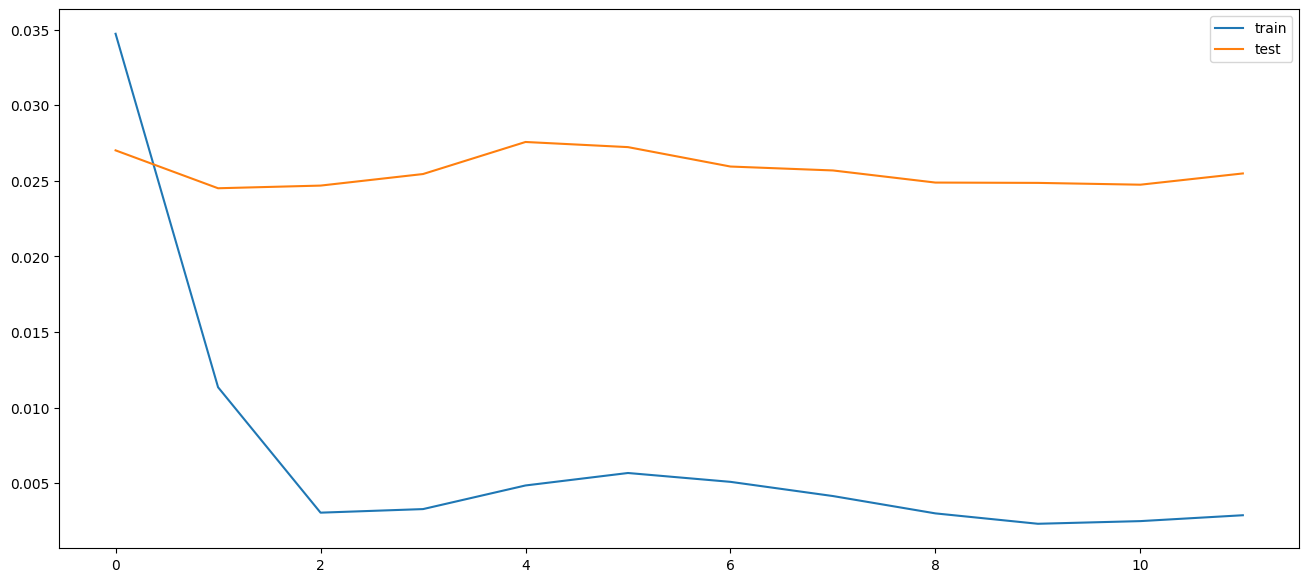

In [77]:
plt.figure(figsize=(16,7))
plt.plot(history.history['loss'], label='train')

plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


In [78]:
# Transformation to original form and making the predictions

# predicted_btc_price_test_data = regressor.predict(testX)
predicted_btc_price_test_data = model_from_saved_checkpoint.predict(testX)

predicted_btc_price_test_data = scaler_test.inverse_transform(predicted_btc_price_test_data.reshape(-1, 1))

test_actual = scaler_test.inverse_transform(testY.reshape(-1, 1))

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step


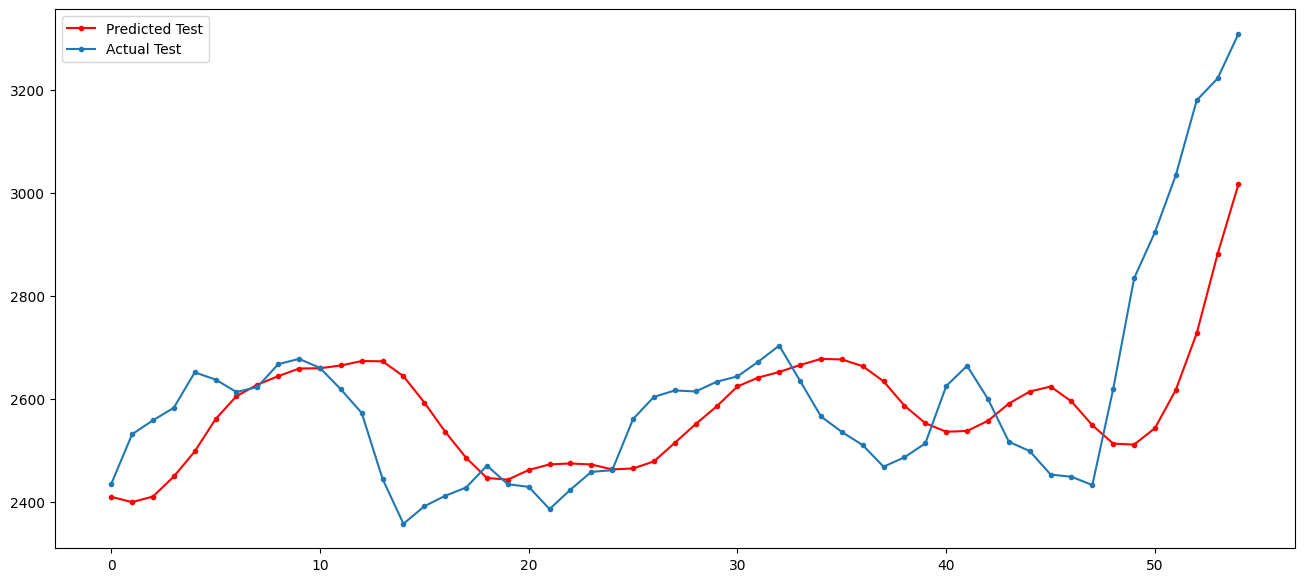

In [79]:
plt.figure(figsize=(16,7))

plt.plot(predicted_btc_price_test_data, 'r', marker='.', label='Predicted Test')

plt.plot(test_actual, marker='.', label='Actual Test')

plt.legend()
plt.show()

In [80]:
# Transformation to original form and making the predictions

predicted_btc_price_train_data = model_from_saved_checkpoint.predict(trainX)

predicted_btc_price_train_data = scaler_train.inverse_transform(predicted_btc_price_train_data.reshape(-1, 1))

train_actual = scaler_train.inverse_transform(trainY.reshape(-1, 1))

81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


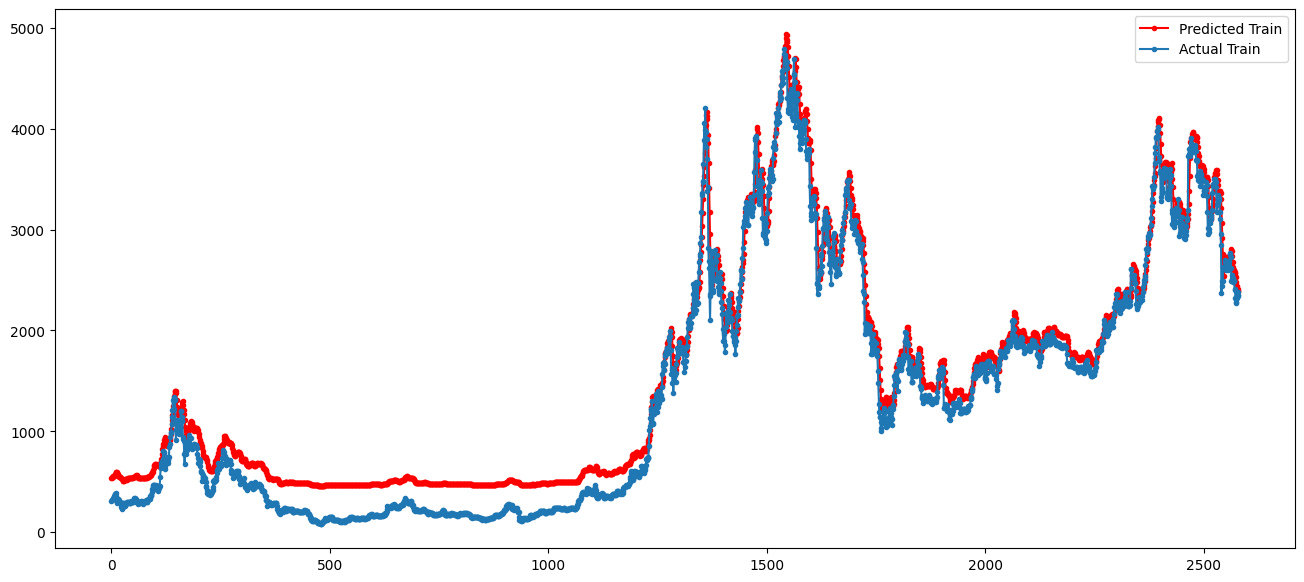

In [81]:
plt.figure(figsize=(16,7))

plt.plot(predicted_btc_price_train_data, 'r', marker='.', label='Predicted Train')

plt.plot(train_actual, marker='.', label='Actual Train')

plt.legend()
plt.show()

In [82]:
rmse_lstm_test = math.sqrt(mean_squared_error(test_actual, predicted_btc_price_test_data))

print('Test RMSE: %.3f' % rmse_lstm_test)

# With 2 Layers + Dropout + lookback=5 => I got - Test RMSE: 1666.162  => This seems best

Test RMSE: 159.131


In [83]:
rmse_lstm_train = math.sqrt(mean_squared_error(train_actual, predicted_btc_price_train_data))

print('Test RMSE: %.3f' % rmse_lstm_train)

# With 2 Layers + Dropout + lookback=5 => I got - Test RMSE: 1047.916  => This seems best

Test RMSE: 229.636


In [84]:
testX
testX.shape

(55, 5, 1)

In [85]:
lookback_period = 5

# That is the original Trading data ended on 30-Oct-2021, but now I am going to forecast for Future 5 days beyond 30-Oct-2021

testX_last_5_days = testX[testX.shape[0] - lookback_period :  ]

testX_last_5_days.shape

(5, 5, 1)

In [86]:
testX_last_5_days


array([[[0.15924999],
        [0.15491726],
        [0.13925122],
        [0.32265293],
        [0.5334471 ]],

       [[0.15491726],
        [0.13925122],
        [0.32265293],
        [0.5334471 ],
        [0.62167145]],

       [[0.13925122],
        [0.32265293],
        [0.5334471 ],
        [0.62167145],
        [0.73046687]],

       [[0.32265293],
        [0.5334471 ],
        [0.62167145],
        [0.73046687],
        [0.87318015]],

       [[0.5334471 ],
        [0.62167145],
        [0.73046687],
        [0.87318015],
        [0.91486218]]])

In [87]:
predicted_5_days_forecast_price_test_x = []

for i in range(5):
  predicted_forecast_price_test_x = model_from_saved_checkpoint.predict(testX_last_5_days[i:i+1])

  predicted_forecast_price_test_x = scaler_test.inverse_transform(predicted_forecast_price_test_x.reshape(-1, 1))
  # print(predicted_forecast_price_test_x)
  predicted_5_days_forecast_price_test_x.append(predicted_forecast_price_test_x)

print("Forecast for the next 5 Days Beyond the actual trading days ", np.array(predicted_5_days_forecast_price_test_x))
# That is the original Trading data ended on 30-Oct-2021, but now I am going to forecast beyond 30-Oct-2021

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Forecast for the next 5 Days Beyond the actual trading days  [[[2543.4573]]

 [[2617.8413]]

 [[2727.4897]]

 [[2881.09  ]]

 [[3016.6533]]]


In [88]:
predicted_5_days_forecast_price_test_x = np.array(predicted_5_days_forecast_price_test_x)

predicted_5_days_forecast_price_test_x.shape

(5, 1, 1)

In [89]:
predicted_btc_price_test_data.shape


(55, 1)

In [90]:
predicted_btc_price_test_data

array([[2410.2556],
       [2399.9224],
       [2410.8398],
       [2449.6638],
       [2498.2043],
       [2560.9727],
       [2605.485 ],
       [2627.6682],
       [2644.2808],
       [2658.9849],
       [2659.5972],
       [2664.9365],
       [2673.5708],
       [2673.016 ],
       [2644.201 ],
       [2593.1455],
       [2536.4185],
       [2485.967 ],
       [2446.724 ],
       [2443.5886],
       [2462.3005],
       [2473.11  ],
       [2474.9824],
       [2472.9087],
       [2463.3594],
       [2465.2415],
       [2478.9922],
       [2515.0168],
       [2551.417 ],
       [2585.507 ],
       [2624.3047],
       [2641.5916],
       [2652.3557],
       [2665.825 ],
       [2677.757 ],
       [2676.6067],
       [2663.5986],
       [2634.1748],
       [2586.951 ],
       [2552.945 ],
       [2536.43  ],
       [2537.9658],
       [2557.6377],
       [2591.0698],
       [2614.403 ],
       [2624.0684],
       [2595.2505],
       [2549.0776],
       [2513.4128],
       [2511.4966],


In [91]:
predicted_5_days_forecast_price_test_x


array([[[2543.4573]],

       [[2617.8413]],

       [[2727.4897]],

       [[2881.09  ]],

       [[3016.6533]]], dtype=float32)

In [92]:
predicted_5_days_forecast_price_test_x = predicted_5_days_forecast_price_test_x.flatten()

predicted_5_days_forecast_price_test_x

array([2543.4573, 2617.8413, 2727.4897, 2881.09  , 3016.6533],
      dtype=float32)

In [93]:
predicted_btc_price_test_data = predicted_btc_price_test_data.flatten()

predicted_btc_price_test_data

array([2410.2556, 2399.9224, 2410.8398, 2449.6638, 2498.2043, 2560.9727,
       2605.485 , 2627.6682, 2644.2808, 2658.9849, 2659.5972, 2664.9365,
       2673.5708, 2673.016 , 2644.201 , 2593.1455, 2536.4185, 2485.967 ,
       2446.724 , 2443.5886, 2462.3005, 2473.11  , 2474.9824, 2472.9087,
       2463.3594, 2465.2415, 2478.9922, 2515.0168, 2551.417 , 2585.507 ,
       2624.3047, 2641.5916, 2652.3557, 2665.825 , 2677.757 , 2676.6067,
       2663.5986, 2634.1748, 2586.951 , 2552.945 , 2536.43  , 2537.9658,
       2557.6377, 2591.0698, 2614.403 , 2624.0684, 2595.2505, 2549.0776,
       2513.4128, 2511.4966, 2543.4573, 2617.8416, 2727.4897, 2881.09  ,
       3016.6533], dtype=float32)

In [94]:
predicted_btc_test_concatenated = np.concatenate((predicted_btc_price_test_data, predicted_5_days_forecast_price_test_x))

predicted_btc_test_concatenated

predicted_btc_test_concatenated.shape


(60,)

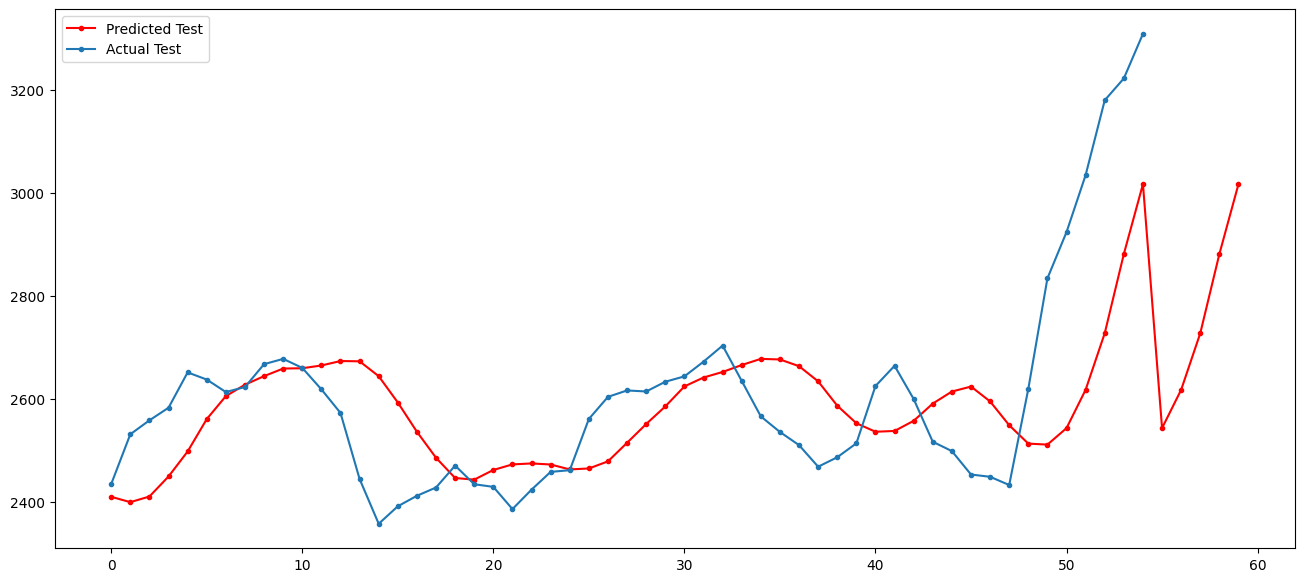

In [95]:
plt.figure(figsize=(16,7))

plt.plot(predicted_btc_test_concatenated, 'r', marker='.', label='Predicted Test')

plt.plot(test_actual, marker='.', label='Actual Test')

plt.legend()

plt.show()